# Calling TYPHOON-OCR-7B on IBM watsonx.ai

In [ ]:
import base64
from io import BytesIO
from PIL import Image
from ibm_watsonx_ai import APIClient
from ibm_watsonx_ai import Credentials
from ibm_watsonx_ai.foundation_models import ModelInference
import requests
from dotenv import load_dotenv
import os


In [ ]:
load_dotenv()

# Configuration - Replace with your credentials
API_KEY = os.getenv("WX_AI_API_KEY")
DEPLOYMENT_ID = os.getenv("WX_AI_DEPLOYMENT_ID")  # The ID of your deployed Typhoon OCR model
URL = os.getenv("WX_AI_URL")  # Change based on your region

def get_iam_token(api_key):
    """Get IBM Cloud IAM token"""
    url = os.getenv("CLOUD_IAM_URL")
    headers = {"Content-Type": "application/x-www-form-urlencoded"}
    data = {
        "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
        "apikey": api_key
    }
    response = requests.post(url, headers=headers, data=data)
    return response.json()["access_token"]

# Function to encode image to base64
def encode_image(image_path):
    """Encode image to base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# Get IAM token
print("Getting IAM token...")
iam_token = get_iam_token(API_KEY)
print("✓ Token received")


# Scoring endpoint URL - Using CHAT API for VLM models
scoring_url = f"{URL}/ml/v1/deployments/{DEPLOYMENT_ID}/text/chat?version=2024-03-19"

# Test OCR on a single image
print("\nTesting Typhoon OCR model...")
print("=" * 60)

# Encode your image
image_path = "/Users/pat/Desktop/custom_FM/images/Screenshot 2568-12-29 at 02.57.05.png"  # Replace with your image path
print(f"Reading image: {image_path}")
image_base64 = encode_image(image_path)
print("✓ Image encoded")

Getting IAM token...
✓ Token received

Testing Typhoon OCR model...
Reading image: /Users/pat/Desktop/custom_FM/images/Screenshot 2568-12-29 at 02.57.05.png
✓ Image encoded


In [ ]:
# You are a precise data extraction assistant. Extract tax invoice information from this Thai tax invoice/receipt document.

# CRITICAL INSTRUCTIONS:
# 1. Extract ONLY printed/typed text that is clearly visible and readable
# 2. IGNORE all handwritten text, signatures, stamps, and annotations
# 3. If a field is not present or unclear, use an empty string ""
# 4. Do NOT guess, infer, or fabricate any values
# 5. Preserve exact formatting for dates, numbers, and Thai text as they appear
# 6. For amounts: extract numbers only (no currency symbols, commas are acceptable)
# 7. For tax IDs: extract exactly 13 digits with no spaces or dashes

# FIELD DEFINITIONS:
# - invoice_number: The document/invoice number (often labeled "เลขที่" or "Invoice No.")
# - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
# - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
# - supplier_address_th: Seller's full address in Thai
# - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
# - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
# - customer_address_th: Buyer's full address in Thai
# - customer_tax_id: Buyer's 13-digit tax identification number
# - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
# - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
# - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
# - line_items: Array of products/services with description, quantity, unit_price, amount

# RESPONSE FORMAT:
# Return ONLY a valid JSON object with NO additional text, markdown formatting, code blocks, or explanations.

# JSON Structure:
# {
#   "invoice_number": "",
#   "invoice_date": "",
#   "supplier_name_th": "",
#   "supplier_address_th": "",
#   "supplier_tax_id": "",
#   "customer_name_th": "",
#   "customer_address_th": "",
#   "customer_tax_id": "",
#   "net_amount": "",
#   "total_tax_amount": "",
#   "total_amount": "",
#   "line_items": [
#     {
#       "description": "",
#       "quantity": "",
#       "unit_price": "",
#       "amount": ""
#     }
#   ]
# }

In [126]:
# Prepare the request payload for chat API
payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": """Extract all text from this image.
                               You are a precise data extraction assistant. Extract tax invoice information from this Thai tax invoice/receipt document.
                                CRITICAL INSTRUCTIONS:
                                1. Extract ONLY printed/typed text that is clearly visible and readable
                                2. IGNORE all handwritten text, signatures, stamps, and annotations
                                3. If a field is not present or unclear, use an empty string ""
                                4. Do NOT guess, infer, or fabricate any values
                                5. Preserve exact formatting for dates, numbers, and Thai text as they appear
                                6. For amounts: extract numbers only (no currency symbols, commas are acceptable)
                                7. For tax IDs: extract exactly 13 digits with no spaces or dashes

                                FIELD DEFINITIONS:
                                - invoice_number: The document/invoice number (often labeled "เลขที่" or "Invoice No.")
                                - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
                                - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
                                - supplier_address_th: Seller's full address in Thai
                                - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
                                - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
                                - customer_address_th: Buyer's full address in Thai
                                - customer_tax_id: Buyer's 13-digit tax identification number
                                - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
                                - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
                                - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
                                - line_items: Array of products/services with description, quantity, unit_price, amount

                                RESPONSE FORMAT:
                                Return ONLY a valid JSON object with NO additional text, markdown formatting, code blocks, or explanations.

                                JSON Structure:
                                {
                                "invoice_number": "",
                                "invoice_date": "",
                                "supplier_name_th": "",
                                "supplier_address_th": "",
                                "supplier_tax_id": "",
                                "customer_name_th": "",
                                "customer_address_th": "",
                                "customer_tax_id": "",
                                "net_amount": "",
                                "total_tax_amount": "",
                                "total_amount": "",
                                "line_items": [
                                    {
                                    "description": "",
                                    "quantity": "",
                                    "unit_price": "",
                                    "amount": ""
                                    }
                                ]
                            }
                    """
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        }
    ],
    "parameters": {
        "max_tokens": 1000,
        "temperature": 0.0,
        "top_p": 0.9
    }
}

In [136]:
# Prepare the request payload for chat API
payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Extract all text from this image."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{image_base64}"
                    }
                }
            ]
        }
    ],
    "parameters": {
        "max_tokens": 1000,
        "temperature": 0.0,
        "top_p": 0.9
    }
}

{'messages': [{'role': 'user', 'content': [{'type': 'text', 'text': 'Extract all text from this image.'}, {'type': 'image_url', 'image_url': {'url': ''}}]}], 'parameters': {'max_tokens': 1000, 'temperature': 0.0, 'top_p': 0.9}}

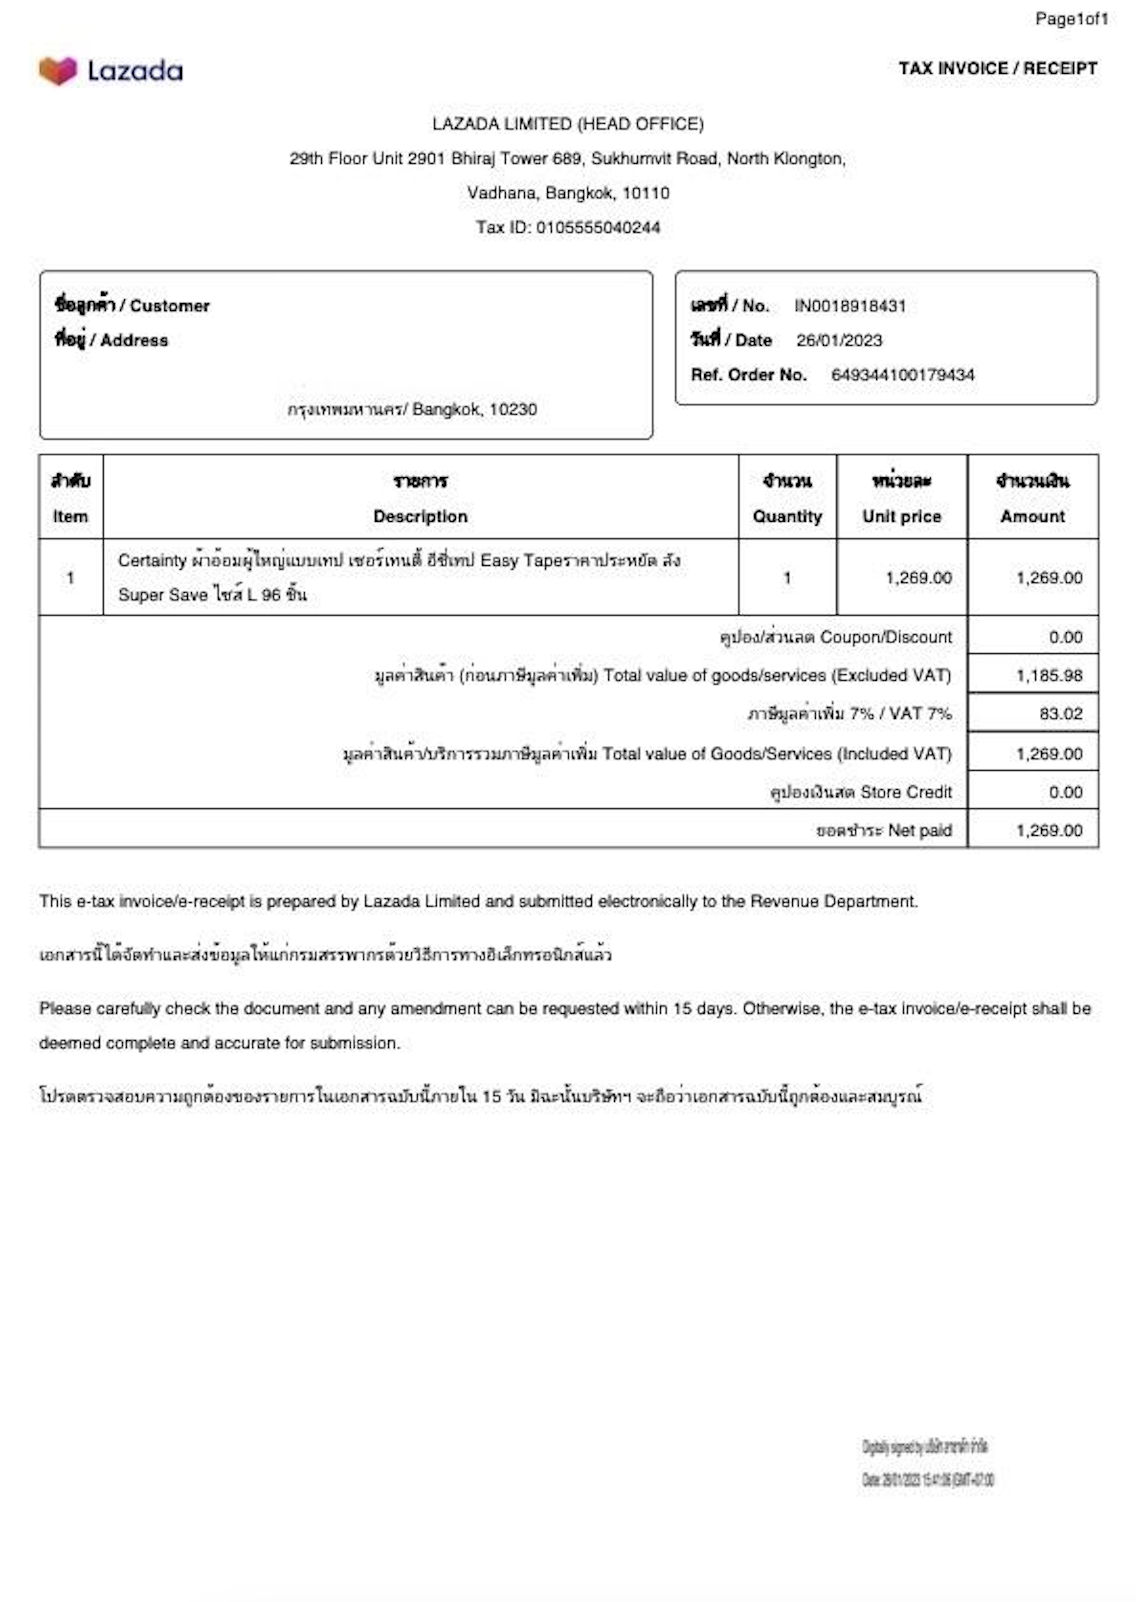

In [133]:
print(payload)

In [137]:
# Make the API request
print("\nCalling Typhoon OCR model...")
headers = {
    "Authorization": f"Bearer {iam_token}",
    "Content-Type": "application/json",
    "Accept": "application/json"
}
response = requests.post(scoring_url, headers=headers, json=payload)
if response.status_code == 200:
    result = response.json()
    extracted_text = result["choices"][0]["message"]["content"]
    print(extracted_text)
    


Calling Typhoon OCR model...
{"natural_text": "<logo>Lazada</logo>\n\nTAX INVOICE / RECEIPT\n\nLAZADA LIMITED (HEAD OFFICE)\n29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton,\nVadhana, Bangkok, 10110\nTax ID: 0105555040244\n\nชื่อลูกค้า / Customer : เลขที่/No.\nที่อยู่ / Address : Date\nกรุงเทพมหานคร/ Bangkok, 10230\nRef. Order No.\nIN0018918431\n26/01/2023\n649344100179434\n\n<table border=\"1\">\n<tr>\n<td>ลำดับ Item</td>\n<td>Description</td>\n<td>จำนวน Quantity</td>\n<td>หน่วยละ Unit price</td>\n<td>จำนวนเงิน Amount</td>\n</tr>\n<tr>\n<td>1</td>\n<td>Certainty ผ้าอ้อมผู้ใหญ่แบบแทป เชอร์เทนส์ อีซี่เทป Easy Taperedาประยุบต ฟัง Super Save ไซส์ L 96 ชิ้น</td>\n<td>1</td>\n<td>1,269.00</td>\n<td>1,269.00</td>\n</tr>\n</table>\n\nคูปอง/ส่วนลด Coupon/Discount : 0.00\nมูลค่าสินค้า (ก่อนภาษีมูลค่าเพิ่ม) Total value of goods/services (Excluded VAT) : 1,185.98\nภาษีมูลค่าเพิ่ม 7% / VAT 7% : 83.02\nมูลค่าสินค้าบริการรวมภาษีมูลค่าเพิ่ม Total value of Goods/Services (Includ

# Calling GPT-OSS-120B on IBM watsonx.ai

In [ ]:
# import os
from ibm_watsonx_ai import APIClient, Credentials
from ibm_watsonx_ai.foundation_models import ModelInference

# --- Configuration ---
API_KEY = os.getenv("WX_AI_API_KEY")
URL = os.getenv("WX_AI_URL")
PROJECT_ID = os.getenv("WX_AI_PROJECT_ID")

MODEL_ID = "openai/gpt-oss-120b"

credentials = Credentials(
    url=URL,
    api_key=API_KEY
)

client = APIClient(credentials)
client.set.default_project(PROJECT_ID)

print("✓ Client initialized and project set.")

✓ Client initialized and project set.


In [139]:
parameters = {
    "decoding_method": "greedy",
    "max_new_tokens": 1500,
    "repetition_penalty": 1.1,
    "reasoning_effort": "low" # Options: "low", "medium", "high"
}

model = ModelInference(
    model_id=MODEL_ID,
    params=parameters,
    credentials=credentials,
    project_id=PROJECT_ID
)

print(f"✓ Model {MODEL_ID} initialized with reasoning_effort='low'.")

✓ Model openai/gpt-oss-120b initialized with reasoning_effort='low'.


In [ ]:
raw_text = extracted_text

prompt = f"""Extract information from the following text into valid JSON format.

  TEXT TO PROCESS:
  {raw_text}

  FIELD DEFINITIONS:
  - invoice_number: The document/invoice number (often labeled "Tax inv. No.", "Invoice No" or "เลขที่")
  - invoice_date: Date as printed (format: DD/MM/YYYY or as shown)
  - supplier_name_th: Seller's name in Thai (section labeled "ผู้ขาย" or "Seller"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
  - supplier_address_th: Seller's full address in Thai
  - supplier_tax_id: Seller's 13-digit tax identification number (เลขประจำตัวผู้เสียภาษี)
  - customer_name_th: Buyer's name in Thai (section labeled "ผู้ซื้อ" or "Buyer"). Exclude branch designations like "(สำนักงานใหญ่)" or "(สาขา...)"
  - customer_address_th: Buyer's full address in Thai
  - customer_tax_id: Buyer's 13-digit tax identification number
  - net_amount: Subtotal amount before VAT (มูลค่าสินค้า/บริการ)
  - total_tax_amount: VAT amount (ภาษีมูลค่าเพิ่ม 7%)
  - total_amount: Grand total including VAT (รวมทั้งสิ้น/Total/Grand Total/ยอดสุทธิ)
  - line_items: Array of products/services with description, quantity, unit_price, amount


  JSON Structure:
  {{
    "invoice_number": "",
    "invoice_date": "",
    "supplier_name_th": "",
    "supplier_address_th": "",
    "supplier_tax_id": "",
    "customer_name_th": "",
    "customer_address_th": "",
    "customer_tax_id": "",
    "net_amount": "",
    "total_tax_amount": "",
    "total_amount": "",
    "line_items": [
      {{
        "description": "",
        "quantity": "",
        "unit_price": "",
        "amount": ""
      }}
    ]
  }}

  CRITICAL: Return ONLY a valid JSON object. No explanation, no markdown blocks, no thinking process."""

messages = [
    {
        "role": "system",
        "content": "You are a precise information extraction assistant. You output raw JSON only."
    },
    {
        "role": "user",
        "content": prompt
    }
]

print(f"Calling model with Chat API (low reasoning effort)...\n")
response = model.chat(messages=messages)

print("--- Model Response ---")
if 'choices' in response:
    content = response['choices'][0]['message']['content']
    print(content)
else:
    print(response)

Calling model with Chat API (low reasoning effort)...



/Users/pat/Desktop/custom_FM/.venv/lib/python3.13/site-packages/ibm_watsonx_ai/foundation_models/inference/base_model_inference.py:1202: UserWarning: Parameters [decoding_method, max_new_tokens] is/are not recognized and will be ignored.
  warn(invalid_params_warning)


--- Model Response ---
{
  "invoice_number": "IN0018918431",
  "invoice_date": "26/01/2023",
  "supplier_name_th": "LAZADA LIMITED",
  "supplier_address_th": "29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110",
  "supplier_tax_id": "0105555040244",
  "customer_name_th": "",
  "customer_address_th": "กรุงเทพมหานคร/ Bangkok, 10230",
  "customer_tax_id": "",
  "net_amount": "1,185.98",
  "total_tax_amount": "83.02",
  "total_amount": "1,269.00",
  "line_items": [
    {
      "description": "Certainty ผ้าอ้อมผู้ใหญ่แบบแทป เชอร์เทนส์ อีซี่เทป Easy Tapered ประยุบต ฟัง Super Save ไซส์ L 96 ชิ้น",
      "quantity": "1",
      "unit_price": "1,269.00",
      "amount": "1,269.00"
    }
  ]
}


In [141]:
print(content)

{
  "invoice_number": "IN0018918431",
  "invoice_date": "26/01/2023",
  "supplier_name_th": "LAZADA LIMITED",
  "supplier_address_th": "29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110",
  "supplier_tax_id": "0105555040244",
  "customer_name_th": "",
  "customer_address_th": "กรุงเทพมหานคร/ Bangkok, 10230",
  "customer_tax_id": "",
  "net_amount": "1,185.98",
  "total_tax_amount": "83.02",
  "total_amount": "1,269.00",
  "line_items": [
    {
      "description": "Certainty ผ้าอ้อมผู้ใหญ่แบบแทป เชอร์เทนส์ อีซี่เทป Easy Tapered ประยุบต ฟัง Super Save ไซส์ L 96 ชิ้น",
      "quantity": "1",
      "unit_price": "1,269.00",
      "amount": "1,269.00"
    }
  ]
}


In [142]:
import json

data = json.loads(content)

print(data)
print(type(data)) 


{'invoice_number': 'IN0018918431', 'invoice_date': '26/01/2023', 'supplier_name_th': 'LAZADA LIMITED', 'supplier_address_th': '29th Floor Unit 2901 Bhiraj Tower 689, Sukhumvit Road, North Klongton, Vadhana, Bangkok, 10110', 'supplier_tax_id': '0105555040244', 'customer_name_th': '', 'customer_address_th': 'กรุงเทพมหานคร/ Bangkok, 10230', 'customer_tax_id': '', 'net_amount': '1,185.98', 'total_tax_amount': '83.02', 'total_amount': '1,269.00', 'line_items': [{'description': 'Certainty ผ้าอ้อมผู้ใหญ่แบบแทป เชอร์เทนส์ อีซี่เทป Easy Tapered ประยุบต ฟัง Super Save ไซส์ L 96 ชิ้น', 'quantity': '1', 'unit_price': '1,269.00', 'amount': '1,269.00'}]}
<class 'dict'>


In [143]:
import json

# Write JSON file
with open("/Users/pat/Desktop/custom_FM/working/comparison/result/updated_prompt_result/output_PTV-001_V2.json", "w", encoding="utf-8") as f:
    json.dump(
        data,
        f,
        ensure_ascii=False,  # keep Thai characters readable
        indent=2             # pretty print
    )

print("JSON file created")

JSON file created
